In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import cv2

Identifying Region of Interest (ROI) - MANUALLY

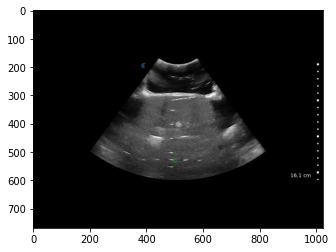

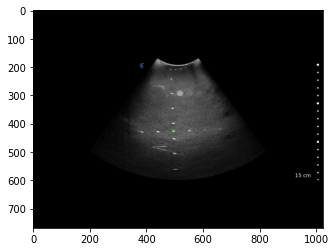

In [159]:
image_path = 'C:/Users/abhip/Desktop/School/MQP/Ultrasound_Needle_Insertion_Software_MQP/Data/materials_test_V2/PP bottom/capture_11_2023-02-04T15-37-44.jpeg'
groundTruth_path = 'C:/Users/abhip/Desktop/School/MQP/Ultrasound_Needle_Insertion_Software_MQP/Data/materials_test_V2/ground_truth_materialTest.jpeg'
#test image
test_image = cv2.imread(image_path)
test_image_visual = test_image.copy()

#ground truth image
ground_truth = cv2.imread(groundTruth_path) #using the pure water sample as he ground truth value
ground_truth_visual = ground_truth.copy()

#bounding region of near field objects
y1,y2 = (495,525), (505,535) #top left corner is y1, bottom right corner is y2

cv2.rectangle(test_image_visual,y1,y2,(0,255,0),1)
plt.figure()
plt.imshow(test_image_visual)

#bounding region of near field objects
y1,y2 = (490,420), (500,430) #top left corner is y1, bottom right corner is y2

cv2.rectangle(ground_truth_visual,y1,y2,(0,255,0),1)
plt.figure()
plt.imshow(ground_truth_visual)

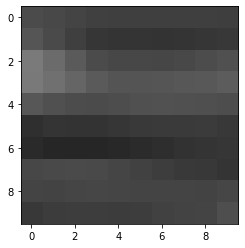

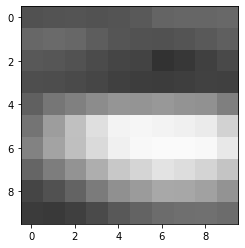

In [160]:
roi_object = test_image[(525):(535), (495):(505)] #format is [y1:y2, x1:x2]
roi_object_gt = ground_truth[420:(430), 490:(500)] #add plus one to x2 and y2 when you want to see all of bounding box
plt.figure()
plt.imshow(roi_object)
plt.figure()
plt.imshow(roi_object_gt)

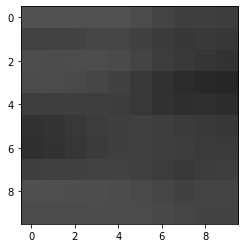

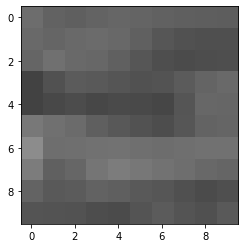

In [161]:
surrounding_tissue = test_image[(525):(535), (495+17):(505+17)] #background region --> same box size next to target region
surrounding_tissue_gt = ground_truth[420:430, (490+12):(500+12)]
plt.figure()
plt.imshow(surrounding_tissue)
plt.figure()
plt.imshow(surrounding_tissue_gt)

Identify ROI through Circle detection

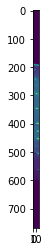

In [172]:
# detect circles in the image
grayscale = cv2.cvtColor(ground_truth[:, (480):(500)], cv2.COLOR_RGB2GRAY)
circles = cv2.HoughCircles(grayscale, cv2.HOUGH_GRADIENT, 1.2, 100)
# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(grayscale, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(grayscale, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

plt.figure()
plt.imshow(grayscale)

Calculating CNR

In [162]:
#CNR VERSION 1

def calculate_cnr(images, object1, object2):
  # Calculate the difference in intensity between the two objects
  intensity_diff = np.abs(np.mean(object1) - np.mean(object2))

  # Calculate the standard deviation of the noise in the images
  noise_std = np.std(images)

  # Calculate the CNR by dividing the intensity difference by the noise standard deviation
  cnr = intensity_diff / noise_std

  return cnr

In [163]:
test_cnr = calculate_cnr(test_image, roi_object,surrounding_tissue)

gt_cnr = calculate_cnr(ground_truth, roi_object_gt,surrounding_tissue_gt)

print(test_cnr)
print(gt_cnr)

relative_percent = (test_cnr/gt_cnr) * 100

print("the combination quality is {} similar when compared to ground truth".format(relative_percent))


0.11005953860623578
1.3729597831772038
the combination quality is 8.016224506703612 similar when compared to ground truth


In [ ]:
#CNR VERSION 2

# Apply filters and thresholding to enhance the contrast in the region of interest
filtered_img = cv2.medianBlur(test_image, 3)
# plt.imshow(filtered_img)
# thresholded_img = cv2.threshold(filtered_img, 100, 255, cv2.THRESH_BINARY)
# plt.imshow(thresholded_img)
# thresholded_img
# # Measure the intensity of the signal in the region of interest
roi_object = filtered_img[300:450, 300:700]

# Measure the intensity of the signal in the region of interest
roi_mean = np.mean(roi_object)

# Measure the intensity of the signal in the surrounding tissue
surrounding_tissue = filtered_img[250:500, 250:750]
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:450], axis=0)
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:700], axis=1)
surrounding_mean = np.mean(surrounding_tissue)

# Calculate the contrast and the noise level
contrast = roi_mean - surrounding_mean
noise = np.std(surrounding_tissue)

# Calculate the CNR
cnr = contrast / noise
cnr

In [ ]:
#CNR VERSION 3
from scipy.stats import norm

# Divide the image into the region of interest and the surrounding tissue
roi = test_image[300:450, 300:700]
surrounding_tissue = test_image[250:500, 250:750]

#remove the region of interest from the surrounding_tissue array
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:450], axis=0)
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:700], axis=1)

# Fit a Gaussian distribution to the intensity values in each region
roi_dist = norm.fit(roi)
surrounding_dist = norm.fit(surrounding_tissue)

# Calculate the peak values of the distributions
roi_peak = roi_dist[0]
surrounding_peak = surrounding_dist[0]

# Calculate the standard deviation of the surrounding tissue
surrounding_std = surrounding_dist[1]

# Calculate the CNR
cnr = (roi_peak - surrounding_peak) / surrounding_std
cnr

In [ ]:
#can use water as the ground truth to identify the reference value

Calculating FWHM

In [ ]:
import numpy as np
import cv2
from scipy.stats import norm

def calculate_fwhm(test_image, roi_input):
  # Load the ultrasound image into a NumPy array
  img = test_image #test_image

  # Apply filters and thresholding to enhance the contrast in the region of interest
  filtered_img = cv2.medianBlur(img, 3)

  # Fit a Gaussian distribution to the intensity values in the region of interest
  roi = roi_input
  
  roi_dist = norm.fit(roi)

  # Calculate the FWHM of the fitted distribution
  roi_peak = roi_dist[0]
  roi_std = roi_dist[1]
  fwhm = 2 * np.sqrt(2 * np.log(2)) * roi_std
  # print(fwhm)

  # Calculate the FWHM of the fitted distribution
  roi_peak = roi_dist[0]
  half_peak = roi_peak / 2
  low_index = np.where(roi < half_peak)[0][0]
  high_index = np.where(roi > half_peak)[0][-1]
  fwhm = high_index - low_index


  # Compare the measured FWHM to a reference value
  reference_fwhm = 127.82 #based off fwhm from ground truth image 

  if fwhm < reference_fwhm:
    print('Excellent image quality')
  elif fwhm >= reference_fwhm and fwhm < 10:
    print('Good image quality')
  elif fwhm >= 10 and fwhm < 20:
    print('Fair image quality')
  else:
    print('Poor image quality')

  return fwhm

In [ ]:
print(calculate_fwhm(test_image, roi_object))
# print(calculate_fwhm(ground_truth, roi_object_gt))

Applying to All Images (USING THE METAL OBJECT AS ROI)

In [ ]:
path = 'C:/Users/abhip/Desktop/School/MQP/Ultrasound_Needle_Insertion_Software_MQP/Data/probe_impedence_V2'
# print(path)

#Saving directory paths to list
base_dir = os.path.join(path)
# print(base_dir)
image_files = glob.glob(base_dir + '/*.jpeg')
# print(test_files)
# len(test_files)

image_list = np.zeros((len(image_files), 768, 1024, 3), dtype=np.uint8)

print('Saving Images to list')

for n, id_ in tqdm(enumerate(image_files), total=len(image_files)):
    path = image_files[n]
    #folder_name = path[4:]
    img = cv2.imread(path)
    image_list[n] = img #fill empty array with values
print('Done!')

In [ ]:
cnr = []
fwhm = []
material_solid_list = []
material_liquid_list = []

for image in tqdm(image_list):
    
    #calculating CNR values
    cnr_value = calculate_cnr(image,0)
    cnr.append(cnr_value)

    #calculating FWHM values
    fwhm_value = calculate_fwhm(image, 0)
    fwhm.append(fwhm_value)


In [ ]:
#Creating Dataframe
data = {'material solid type': material_solid_list,
        'material liquid type': material_liquid_list,
        'CNR': cnr,
        'FWHM': fwhm}
results = pd.DataFrame(data)
results

In [ ]:
import seaborn as sns

#Passing the entire dataset in long-form mode will aggregate over repeated values (each year) to show the mean and 95% confidence interval


sns.lineplot(results, x='impedence values', y='CNR')

#CNR --> the higher the value, the better the image quality

In [ ]:
sns.lineplot(results, x='impedence values', y='FWHM')

#FWHM --> the lower the value, the better the image quality